<a href="https://colab.research.google.com/github/mttcrn/HPAS-project/blob/main/Intrusion%20Detection%20System/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab3: Intrusion Detection System

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import matplotlib as plt

In [6]:
import os
folder_path = "/content/drive/MyDrive/Colab Notebooks/HPAS/eval/"

In [7]:
#input files. Do not touch.
import pandas as pd
import glob
import re

# Load training.csv
training = pd.read_csv(os.path.join(folder_path, "training.csv"))

# Load all evalN.csv files into separate dataframes named evaluationN
eval_files = glob.glob(os.path.join(folder_path, "eval*.csv"))
for f in eval_files:
    match = re.search(r'eval(\d+)\.csv', f)
    if match:
        n = match.group(1)
        df_name = f"evaluation{n}"
        globals()[df_name] = pd.read_csv(f)
        print("found evaluation dataset n°: " + df_name)

found evaluation dataset n°: evaluation6
found evaluation dataset n°: evaluation2
found evaluation dataset n°: evaluation8
found evaluation dataset n°: evaluation4
found evaluation dataset n°: evaluation5
found evaluation dataset n°: evaluation1
found evaluation dataset n°: evaluation3
found evaluation dataset n°: evaluation7


In [27]:
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.preprocessing import MinMaxScaler

def compute_hamming_distance(b1, b2):
    """Compute Hamming distance between two byte strings."""
    return sum(bin(x ^ y).count('1') for x, y in zip(b1, b2))

def hex_to_bytes(hex_str):
    """Convert 16-char hex payload to bytes object."""
    if isinstance(hex_str, str) and len(hex_str) == 16:
        return bytes.fromhex(hex_str)
    return b'\x00' * 8  # fallback for malformed data

def add_hamming_feature(df):
    df = df.copy()
    df['data_bytes'] = df['data_field'].apply(hex_to_bytes)
    df['hamming_dist_prev'] = 0

    for msg_id, group in df.groupby('arbitration_id'):
        group_sorted = group.sort_values('timestamp')
        indices = group_sorted.index.tolist()
        payloads = list(group_sorted['data_bytes'])

        for i in range(1, len(payloads)):
            dist = compute_hamming_distance(payloads[i-1], payloads[i])
            df.at[indices[i], 'hamming_dist_prev'] = dist

    return df.drop(columns=['data_bytes'])

def extract_data(df):
    df = df.copy()

    # Convert data_field to list of bytes
    df['data_bytes'] = df['data_field'].apply(hex_to_bytes)

    # Extract each byte into its own column
    byte_columns = pd.DataFrame(
        df['data_bytes'].apply(lambda b: list(b)).tolist(),
        columns=[f'byte_{i}' for i in range(8)]
    ).astype(np.float32)

    # Total integer value of payload
    df['payload_value'] = df['data_field'].apply(lambda x: int(x, 16) if isinstance(x, str) and len(x) == 16 else 0)
    byte_columns['payload_value'] = df['payload_value']

    return byte_columns

In [36]:
# Make a copy of training in df
df = training.copy()

# Remove useless columns for now
df = df.drop(columns=['attack'])

# Make a set of normal ids
training_ids = set(training['arbitration_id'].unique())

# Check for NaN values
print("NaNs in the dataset:", df.isna().sum().sum())

def extract_features(training):
  df = training.copy()
  # Arbitration Id in int
  df['arbitration_id_int'] = df['arbitration_id'].apply(lambda x: int(x, 16))

  # Message count per ID
  df['msg_count_id'] = df.groupby('arbitration_id')['arbitration_id'].transform('count')

  # Time since beginning
  df['time'] = df['timestamp'] - df['timestamp'].min()

  # Inter arrival time
  df['inter_arrival_time'] = df.groupby('arbitration_id')['timestamp'].diff().fillna(0)

  # Data-fields
  #df_data = extract_data(df)

  # Hammming distance w.r.t. previoud message from the same ID
  df = add_hamming_feature(df)

  # Combine features into one DataFrame
  features = pd.concat([
        df['arbitration_id_int'], df['time'], df['msg_count_id'], df['inter_arrival_time'], df['hamming_dist_prev'].astype(np.float32)
  ], axis=1)

  return features

# Scale all numeric features
print("Extracting features ..")
scaler = MinMaxScaler()
features = extract_features(training)
scaler.fit(features)
features_scaled = pd.DataFrame(scaler.transform(features), columns=features.columns)

features.head()

# Build autoencoder
print("Building model ..")
input_dim = features_scaled.shape[1]

input_layer = tfk.Input(shape=(input_dim,))
x = tfk.layers.Dense(128, activation='relu')(input_layer)
x = tfk.layers.Dense(64, activation='relu')(x)
encoded = tfk.layers.Dense(16, activation='relu')(x)
x = tfk.layers.Dense(64, activation='relu')(encoded)
x = tfk.layers.Dense(128, activation='relu')(x)
output = tfk.layers.Dense(input_dim, activation='sigmoid')(x)

autoencoder = tfk.Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer=tfk.optimizers.Adam(learning_rate=0.001), loss='mse')

# Early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train autoencoder
history = autoencoder.fit(
    features_scaled, features_scaled,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

print("Making predictions..")
train_predictions = autoencoder.predict(features_scaled)
train_reconstruction_errors = np.mean(np.power(features_scaled - train_predictions, 2), axis=1)
threshold_error = np.percentile(train_reconstruction_errors, 99.99)  # fixed threshold found on a paper
print("Fixed threshold (99.99th percentile on training):", threshold_error)

NaNs in the dataset: 0
Extracting features ..
Building model ..
Epoch 1/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.0079 - val_loss: 5.3012e-04
Epoch 2/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 1.2291e-05 - val_loss: 4.8782e-04
Epoch 3/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 7.8627e-06 - val_loss: 4.3335e-04
Epoch 4/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 6.6044e-06 - val_loss: 4.4965e-04
Epoch 5/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 5.5859e-06 - val_loss: 5.5539e-04
Epoch 6/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 5.0154e-06 - val_loss: 5.0688e-04
Epoch 7/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 4.9905e-06 - val_loss: 5.6276e-04
Epoch 8/50
2877/2877 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 5.1037e-06 - val_loss: 5.4758e-04
Making predictions..
28761/28761 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step
Fixed threshold (99.99th percentile on training): 0.003038108158738275


In [60]:
def compute_max_packets_per_window(df, window_seconds=5):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.sort_values(['arbitration_id', 'timestamp'])

    thresholds = {}

    for arb_id, group in df.groupby('arbitration_id'):
        # Set timestamp as index for rolling window
        group = group.set_index('timestamp')

        # Count packets in rolling time windows of size window_seconds
        counts = group['arbitration_id'].rolling(f'{window_seconds}s').count()

        # Get max packets in any window
        max_packets = counts.max()

        thresholds[arb_id] = max_packets

    return thresholds

thresholds_count = compute_max_packets_per_window(training, window_seconds=5)

In [71]:
# result_df needs to be the same as eval_df, with the predicted_attack column
def ids(eval_df):
    global scaler, autoencoder, threshold_error, training_ids, thresholds_count

    # Make a copy of the input
    test_df = eval_df.copy()
    test_df = test_df.drop(columns=['attack'])

    # Extract and scale features
    test_features = extract_features(test_df)
    test = scaler.transform(test_features)

    # Making the predictions
    predictions = autoencoder.predict(test)

    # Compute reconstruction error for each test sample
    reconstruction_errors = np.mean(np.power(test - predictions, 2), axis=1)

    result_df = eval_df.copy()
    result_df['predicted_attack'] = (reconstruction_errors > threshold_error).astype(int)

    # Compute packet counts per window in eval
    eval_df = result_df.copy()
    eval_df['timestamp'] = pd.to_datetime(eval_df['timestamp'], unit='s')
    eval_df = eval_df.sort_values(['arbitration_id', 'timestamp'])

    # Flag as attack if any arbitration_id has more than 120% packets per time window
    window_seconds = 5
    flagged_ids = set()
    for arb_id, group in eval_df.groupby('arbitration_id'):
        group = group.set_index('timestamp')
        counts = group['arbitration_id'].rolling(f'{window_seconds}s').count()
        max_packets_eval = counts.max()

        train_thresh = thresholds_count.get(arb_id, None)
        if train_thresh is not None:
            if max_packets_eval > train_thresh * 1.2: # this value does not influence the results too much, as long as it is higher than 1
                flagged_ids.add(arb_id)

    result_df.loc[result_df['arbitration_id'].isin(flagged_ids), 'predicted_attack'] = 1

    # Mark malformed payloads as NOT attacks
    malformed_mask = ~result_df['data_field'].apply(lambda x: isinstance(x, str) and len(x) == 16)
    result_df.loc[malformed_mask, 'predicted_attack'] = 0

    # All packets with newer arbitration_id are attacks
    result_df.loc[~result_df['arbitration_id'].isin(training_ids), 'predicted_attack'] = 1

    return result_df

running evaluation6
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
running evaluation2
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
running evaluation8
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
running evaluation4
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
running evaluation5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
running evaluation1
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
running evaluation3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
running evaluation7
876/876 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

evaluation6 Evaluation Metrics:
  Accuracy: 0.9875
  Precision: 0.6836
  Recall: 1.0000
  F1_score: 0.8121

evaluation2 Evaluation Metrics:
  Accuracy: 0.9943
  Precision: 0.9858
  Recall: 1.0000
  F1_score: 0.9929

evaluation8 Evaluation Metrics:
  Accuracy: 0.9560
  Precision: 0.0473
  Recall: 0.0357
  F1_score: 0.0407

evaluation4 Evaluation Metrics:
  Accuracy: 0.9530
  Precision: 0.0000
  Recall: 0.0000
  F1_score: 0.0000

evaluation5 Evaluation Metrics:
  Accuracy: 0.9771
  Precision: 0.9398
  Recall

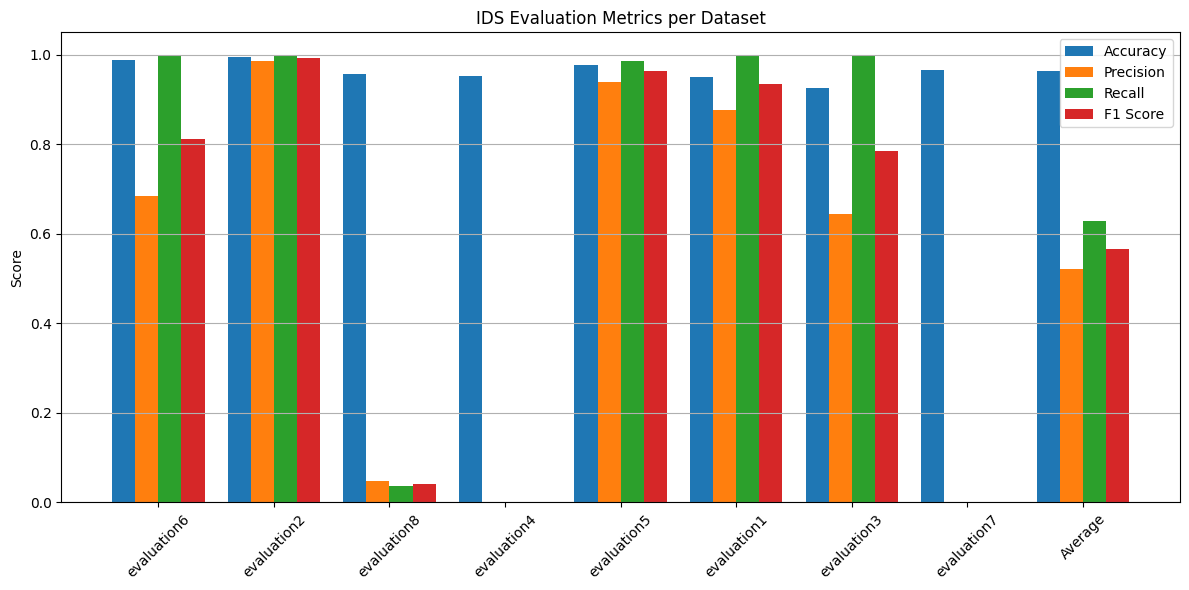


Total Elapsed Time: 19.47 seconds


In [72]:
#evaluation sequence. Do not touch.
import time  # Add this
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

start_time = time.time()  # Start timing

evaluation_metrics = {}
all_globals = list(globals().items())

# Loop through evaluation dataframes
for name, df in all_globals:
    if name.startswith("evaluation") and isinstance(df, pd.DataFrame):
        # Run IDS
        print("running " + name)
        detected_df = ids(df)

        # Compare predictions to ground truth
        y_true = detected_df['attack']
        y_pred = detected_df['predicted_attack']

        # Compute metrics
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1_score': f1_score(y_true, y_pred, zero_division=0),
        }

        evaluation_metrics[name] = metrics

# Compute average metrics
avg_metrics = {
    metric: np.mean([metrics[metric] for metrics in evaluation_metrics.values()])
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']
}
evaluation_metrics['Average'] = avg_metrics

# Display metrics
for name, metrics in evaluation_metrics.items():
    print(f"\n{name} Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

# Plotting
labels = list(evaluation_metrics.keys())
x = np.arange(len(labels))
width = 0.2

# Prepare metric lists
accuracy = [evaluation_metrics[label]['accuracy'] for label in labels]
precision = [evaluation_metrics[label]['precision'] for label in labels]
recall = [evaluation_metrics[label]['recall'] for label in labels]
f1 = [evaluation_metrics[label]['f1_score'] for label in labels]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1 Score')

plt.xticks(x, labels, rotation=45)
plt.ylabel('Score')
plt.title('IDS Evaluation Metrics per Dataset')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# End timing
end_time = time.time()
elapsed_time = end_time - start_time
print(f"\nTotal Elapsed Time: {elapsed_time:.2f} seconds")
